In [1]:
from math import sqrt
import time
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import pickle

def save_obj(obj,name):
    with open(obj,'wb') as f:
        pickle.dump(name,f)
        
def load_obj(obj):
    with open(obj,'rb') as f:
        return pickle.load(f)

    
class MixedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha = 0.5, first_n_estimators = 10, second_n_estimators = 10, eta = 0.025, first_max_depth = 3, second_max_depth = 3, max_features = 30):
        self.alpha = alpha
        self.first_n_estimators = first_n_estimators
        self.second_n_estimators = second_n_estimators
        self.first_max_depth  = first_max_depth 
        self.second_max_depth  = second_max_depth 
        self.eta = eta
        self.max_features = max_features
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.__first_classifier = XGBClassifier(n_estimators = self.first_n_estimators, max_depth = self.first_max_depth, eta = self.eta)
        self.__second_classifier = RandomForestClassifier(n_estimators = self.second_n_estimators, max_depth = self.second_max_depth, max_features = self.max_features)
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.__first_classifier.fit(X, y)
        self.__second_classifier.fit(X, y)
        return self
    
    def predict_proba(self, X):
        check_is_fitted(self, ['X_', 'y_'])
        return (self.alpha * self.__first_classifier.predict_proba(X) + (1 - self.alpha) * self.__second_classifier.predict_proba(X))
    
    def predict(self, X):
        check_is_fitted(self, ['X_', 'y_'])
        X = check_array(X)
        return self.classes_[np.argmax(self.predict_proba(X),axis=1)]

In [2]:
import pandas as pd
import numpy as np


df = pd.read_csv('dataset/telcom_customer_churn.csv')
df.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,Y,434.0,1000005


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

Проверка на дисбаланс классов

In [4]:
df['churn'].value_counts(normalize = True)

0    0.50438
1    0.49562
Name: churn, dtype: float64

10 признаков с максимальным числом пропусков

In [5]:
is_nan = df.isnull().sum()
pd.DataFrame({'Miss Values' : is_nan[is_nan != 0].sort_values(ascending = False).head(10)})

,Miss Values
numbcars,49366
dwllsize,38308
HHstatin,37923
ownrent,33706
dwlltype,31909
lor,30190
income,25436
adults,23019
infobase,22079
hnd_webcap,10189


Гистограммы признаков с пропущенными значениями

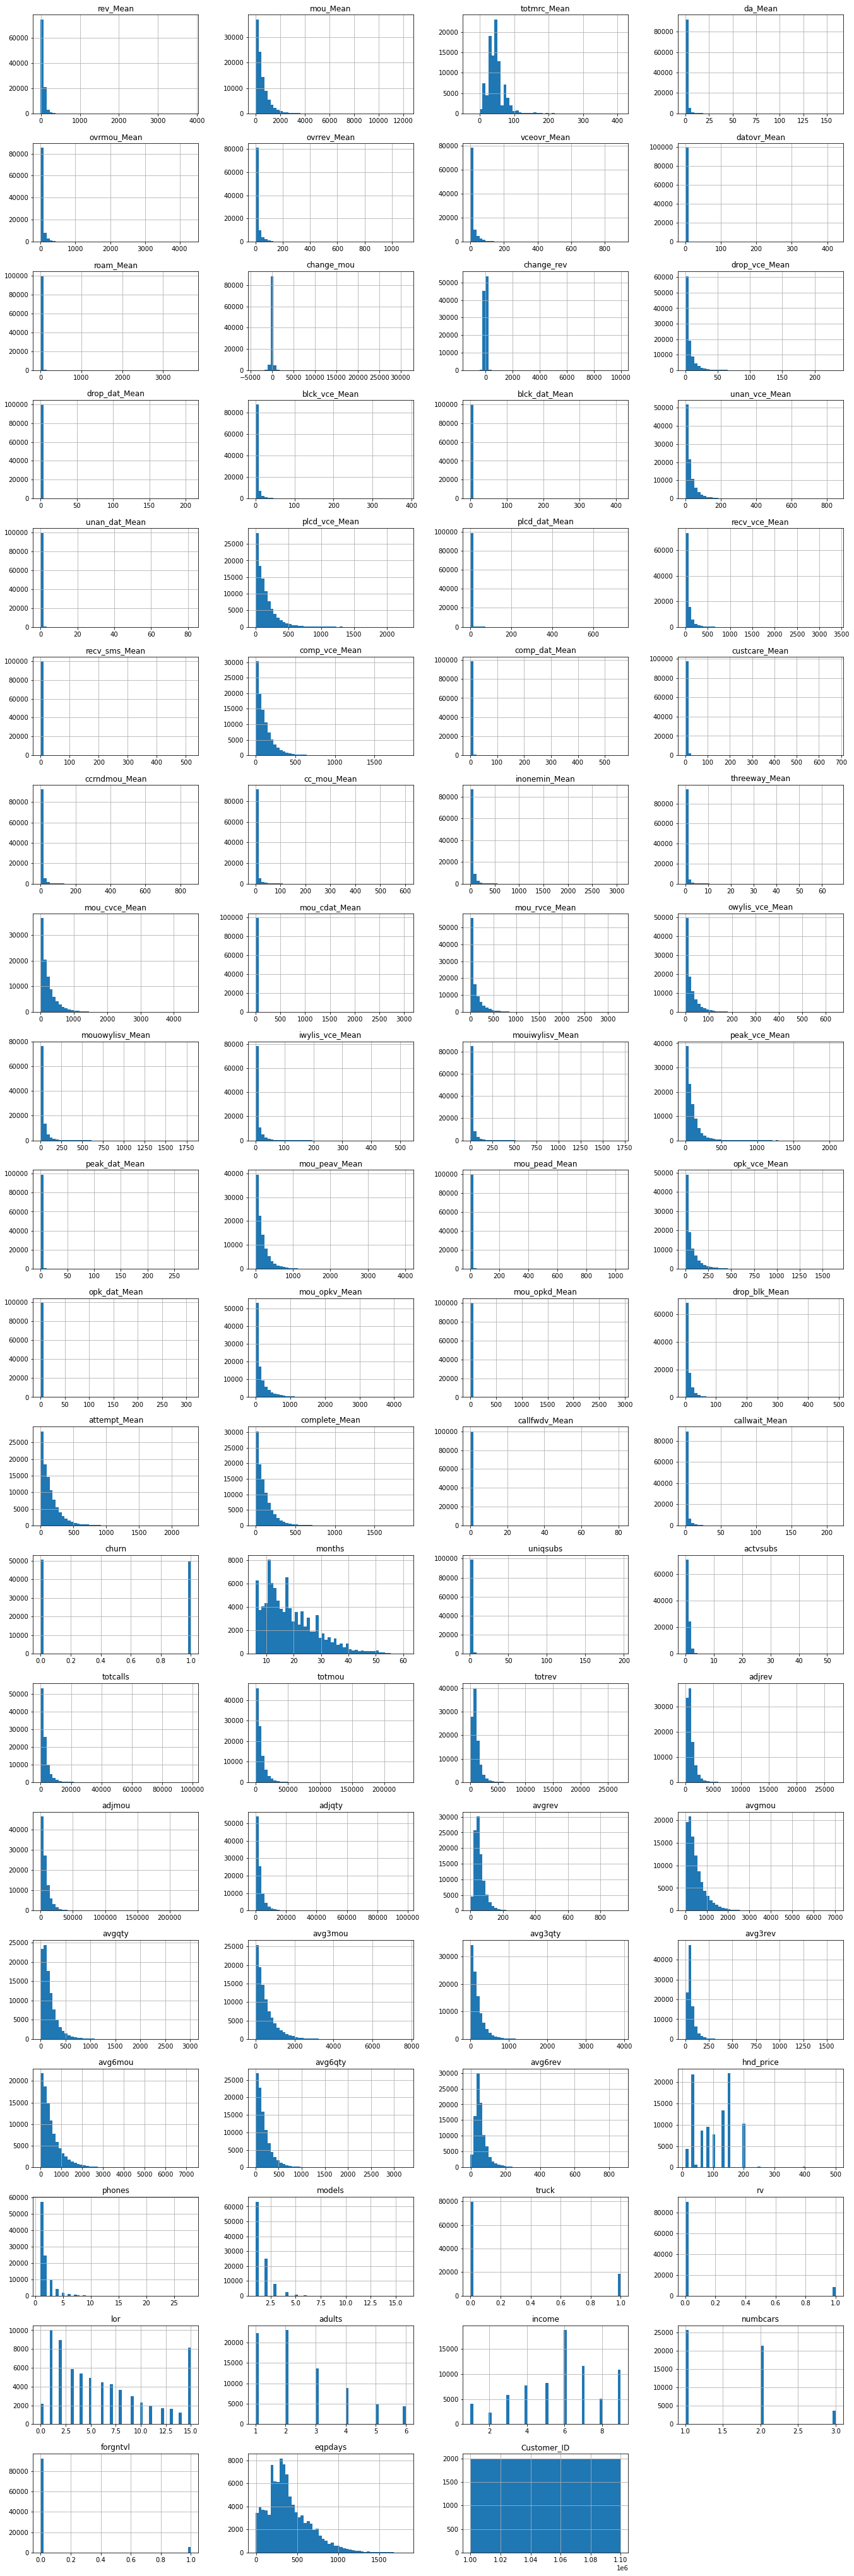

In [6]:
df[list(is_nan.index)].hist(bins=50,figsize=(23,74),layout=(20,4));

Категориальные и количественные признаки

In [7]:
numerical_columns_selector = make_column_selector(dtype_exclude=object)
categorical_columns_selector = make_column_selector(dtype_include=object)

numerical_columns = numerical_columns_selector(df.drop(columns = 'churn'))
categorical_columns = categorical_columns_selector(df.drop(columns = 'churn'))

print('Numerical columns: ', numerical_columns)
print('\nCategorical columns: ', categorical_columns)

Numerical columns:  ['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou', 'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'months', 'uniqsubs', 'actvsubs', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'hnd

In [8]:
def fill_nan_with_median(data, col = []):
    data_copy = data.copy(deep=True)
    for i in col:
        if data_copy[i].isnull().sum()>0:
            data_copy[i] = data_copy[i].fillna(data[i].median())
                            
    return data_copy 

def fill_nan_with_mode(data, col = []):
    data_copy = data.copy(deep=True)
    for i in col:
        if data_copy[i].isnull().sum()>0:
            data_copy[i] = data_copy[i].fillna(data[i].mode()[0])
                            
    return data_copy  

Замену пропусков в количественных признаках произведем заменой на медианное значение, категориальных - модой.

In [9]:
df = fill_nan_with_median(data = df, col = numerical_columns)
df = fill_nan_with_mode(data = df, col = categorical_columns)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          100000 non-null  float64
 1   mou_Mean          100000 non-null  float64
 2   totmrc_Mean       100000 non-null  float64
 3   da_Mean           100000 non-null  float64
 4   ovrmou_Mean       100000 non-null  float64
 5   ovrrev_Mean       100000 non-null  float64
 6   vceovr_Mean       100000 non-null  float64
 7   datovr_Mean       100000 non-null  float64
 8   roam_Mean         100000 non-null  float64
 9   change_mou        100000 non-null  float64
 10  change_rev        100000 non-null  float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

Разбиение на тренировочную и тестовую выборки

In [11]:
data = df.drop(columns = 'churn')
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    data, y, stratify = y, test_size=0.30, random_state=42)

Подготовка данных

In [12]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

X_train = preprocessor.fit_transform(X_train);
X_test = preprocessor.transform(X_test);

In [13]:
pca = PCA(.95)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [14]:
pca.n_components_

61

In [15]:
tree = DecisionTreeClassifier()
forest = RandomForestClassifier() 
xgb = XGBClassifier()
mix = MixedClassifier()

tree_params = {
    'max_features': range(35, 40)}
forest_params = {
    'max_features': range(35, 40), 'n_estimators': range(300,600,100), 'max_depth': range(3,6)} 
xgb_params = {
    'n_estimators': range(300,600,100), 'eta': [0.1, 0.5, 0.9], 'max_depth': range(3,6)}


tree_grid = GridSearchCV(tree, tree_params,cv=5, verbose=True, n_jobs=-1)
forest_grid = GridSearchCV(forest, forest_params,cv=5, verbose=True, n_jobs=-1)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, verbose=True, n_jobs=-1)

print('\n********************* Selection of parameters *********************\n')
tree_grid.fit(X_train, y_train)
print("Desicion Tree - Params: {}, Score: {}".format(tree_grid.best_params_, round(tree_grid.best_score_,3)))
forest_grid.fit(X_train, y_train)
print("Random Forest - Params: {}, Score: {}".format(forest_grid.best_params_, round(forest_grid.best_score_,3)))
xgb_grid.fit(X_train, y_train)
print("XGBoost - Params: {}, Score: {}".format(xgb_grid.best_params_, round(xgb_grid.best_score_,3)))

mix_params = {
    'alpha': [round(0.05*x,2) for x in range(1,21)],
    'first_n_estimators': [xgb_grid.best_params_['n_estimators']],
    'eta': [xgb_grid.best_params_['eta']], 
    'first_max_depth': [xgb_grid.best_params_['max_depth']], 
    'second_n_estimators': [forest_grid.best_params_['n_estimators']],
    'second_max_depth': [forest_grid.best_params_['max_depth']],
    'max_features': [forest_grid.best_params_['max_features']]
}
mix_grid = GridSearchCV(mix, mix_params, cv=5, verbose=True, n_jobs=-1)
mix_grid.fit(X_train, y_train)
print("MixedClassifier - Params: {}, Score: {}".format(mix_grid.best_params_, round(mix_grid.best_score_,3)))
models = [
    DecisionTreeClassifier(max_features=tree_grid.best_params_['max_features']), 
    RandomForestClassifier(max_features=forest_grid.best_params_['max_features'],n_estimators=forest_grid.best_params_['n_estimators'], max_depth = forest_grid.best_params_['max_depth']),
    XGBClassifier(eta=xgb_grid.best_params_['eta'], max_depth=xgb_grid.best_params_['max_depth'], n_estimators=xgb_grid.best_params_['n_estimators']), 
    MixedClassifier(alpha=mix_grid.best_params_['alpha'], eta=mix_grid.best_params_['eta'], first_max_depth=mix_grid.best_params_['first_max_depth'],
        first_n_estimators=mix_grid.best_params_['first_n_estimators'], max_features=mix_grid.best_params_['max_features'], 
        second_n_estimators=mix_grid.best_params_['second_n_estimators'])
]

print('\n********************* Validation Check *********************\n')
names  = ["Decision Tree", "Random Forest", "XGB", "MIX"]
for model,name in zip(models, names):
    start = time.time( )
    model.fit(X_train,y_train)
        
    predicted = model.predict(X_test)
    auc = roc_auc_score(y_test, predicted)

    print("Model: {}, ROC-AUC: {}".format(name,round(auc,3)))
    print('time', time.time() - start, '\n')


********************* Selection of parameters *********************

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Desicion Tree - Params: {'max_features': 36}, Score: 0.53
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Random Forest - Params: {'max_depth': 5, 'max_features': 35, 'n_estimators': 400}, Score: 0.585
Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoost - Params: {'eta': 0.1, 'max_depth': 4, 'n_estimators': 300}, Score: 0.601
Fitting 5 folds for each of 20 candidates, totalling 100 fits
MixedClassifier - Params: {'alpha': 0.8, 'eta': 0.1, 'first_max_depth': 4, 'first_n_estimators': 300, 'max_features': 35, 'second_max_depth': 5, 'second_n_estimators': 400}, Score: 0.601

********************* Validation Check *********************

Model: Decision Tree, ROC-AUC: 0.525
time 4.3196189403533936 

Model: Random Forest, ROC-AUC: 0.581
time 347.2363336086273 

Model: XGB, ROC-AUC: 0.598
time 35.899970293045044 

Model: MIX, ROC-AUC:

In [16]:
xgb = XGBClassifier(n_estimators = 1000, eta = 0.3, max_depth = 5)
xgb.fit(X_train, y_train)

predicted = xgb.predict(X_test)
auc = roc_auc_score(y_test, predicted)

In [17]:
auc

0.5763299862173042